# Does SSA (Sistem Satu Arah - Unidirectional Road System) implementation on some road segments in Depok city make any improvement to the traffic condition of the city?

- Comparing the traffic conditions (in terms of travel time) between various locations in Depok city before (< July 2017) and after (> July 2017) the implementation of SSA
- Using HERE REST API to derive past traffic conditions

### Limitations
Apparently HERE REST API only provides precise historical travel times from 1 January 2018 onward. Travel times before that time are averaged out and categorised into 'morning travel' and 'evening travel'.

# data prep

In [1]:
import pandas as pd
import numpy as np
import sys
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_heatmap
%matplotlib inline

df1 = pd.read_csv('data_2017_2018.csv')
df2 = pd.read_csv('data_2019.csv')
dfs = [df1, df2]

In [2]:
df = df1.append(df2)

In [3]:
def get_day(dt):
    year, month, day = (int(x) for x in dt.split('-'))
    day_no = datetime.date(year, month, day).weekday()
    return calendar.day_name[day_no]

In [4]:
time_groups_dict = {'Monday_Morning': '01_Monday_Morning',
                    'Monday_Evening': '02_Monday_Evening',
                    'Wednesday_Morning': '03_Wednesday_Morning',
                    'Wednesday_Evening': '04_Wednesday_Evening',
                    'Friday_Morning': '05_Friday_Morning',
                    'Friday_Evening': '06_Friday_Evening',
                    'Saturday_Morning': '07_Saturday_Morning',
                    'Saturday_Evening': '07_Saturday_Evening'}

In [5]:
df['year'] = df['clock_time'].apply(lambda t: int(t[:4]))
df['time_of_day'] = df['clock_time'].apply(lambda t: 'Morning' if int(t[11:13]) < 10 else 'Evening')
df['day'] = df['clock_time'].apply(lambda t: get_day(t[:10]))
df['time_groups'] = df['day'] + '_' + df['time_of_day']
df['time_groups'] = df['time_groups'].map(time_groups_dict)

## list of points within the analysis

In [6]:
for i in sorted(set(list(df['From']))): print(i)

01 pertigaan juanda-margonda arah ramanda
02 pertigaan ramanda arah terminal depok
03 pertigaan ramanda arah depok mall
04 pasar baru jln nusantara
05 jln raya sawangan
06 rumah (sarikaya)
07 dewi sartika, perlimaan, lajur lama
08 dewi sartika, perlimaan, lajur baru
09 jln kartini - dewi sartika, arah margonda
10 jln kartini - dewi sartika, arah citayam
11 ITC depok
12 sebrang ITC depok


## Aggregate changes between each day-time of day combinations

median values are shown under each boxplot


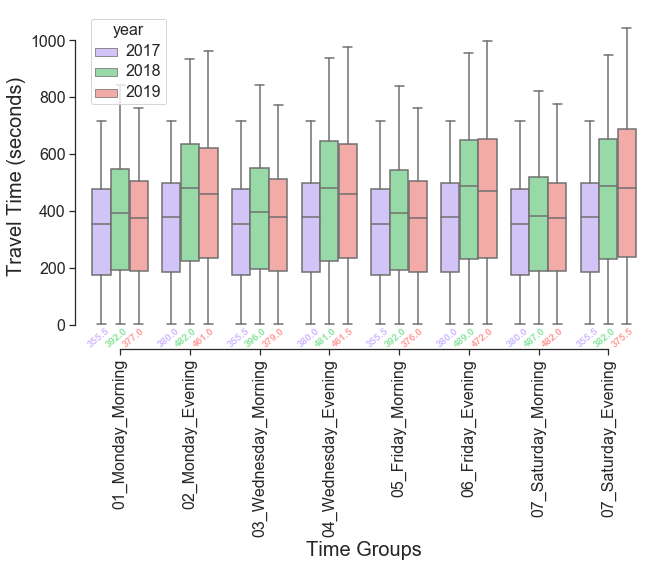

In [7]:
sns.set(style="ticks", palette="pastel")

fig, ax = plt.subplots(figsize=(10,6))

g = sns.boxplot(x='time_groups', y='time', hue='year', palette=['m','g','r'], data=df)

sns.despine(offset=10, trim=True)

for item in g.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(16)
    
for item in g.get_yticklabels():
    item.set_fontsize(16)
    
plt.xlabel('Time Groups', fontsize=20)
plt.ylabel('Travel Time (seconds)', fontsize=20)

plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

# MEDIAN SERIES
pctl50 = df.groupby(['time_groups', 'year'])['time'].median()
pctl50_labels = [str(np.round(s, 2)) for s in pctl50]

# GROUP INDEX TUPLES
grps = [(i, 3*i, 3*i+1, 3*i+2) for i in range(8)]
pos = range(len(pctl50))

# ADJUST HORIZONTAL ALIGNMENT WITH MORE SERIES
for tick, label in zip(grps, ax.get_xticklabels()):
    ax.text(tick[0]-0.3, -30, pctl50_labels[tick[1]], 
               ha='center', size='small', color='m', weight='semibold', rotation=40)
    ax.text(tick[0]-0.05, -30, pctl50_labels[tick[2]], 
               ha='center', size='small', color='g', weight='semibold', rotation=40)
    ax.text(tick[0]+0.2, -30, pctl50_labels[tick[3]], 
               ha='center', size='small', color='r', weight='semibold', rotation=40)
    
print('median values are shown under each boxplot')

## changes between each origin-destination points

In [8]:
#data prep
df_2017 = df.loc[df['year']==2017]
df_2017_raw = df_2017.groupby(['From', 'To'])['time'].median().unstack(level=1)
df_2017_raw.fillna(0, inplace=True)

df_2018 = df.loc[df['year']==2018]
df_2018_raw = df_2018.groupby(['From', 'To'])['time'].median().unstack(level=1)
df_2018_raw.fillna(0, inplace=True)

df_2019 = df.loc[df['year']==2019]
df_2019_raw = df_2019.groupby(['From', 'To'])['time'].median().unstack(level=1)
df_2019_raw.fillna(0, inplace=True)

difference_raw = df_2019_raw - df_2018_raw
difference_perc = difference_raw / df_2018_raw
difference_perc.fillna(0, inplace=True)

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c5313acf8>)

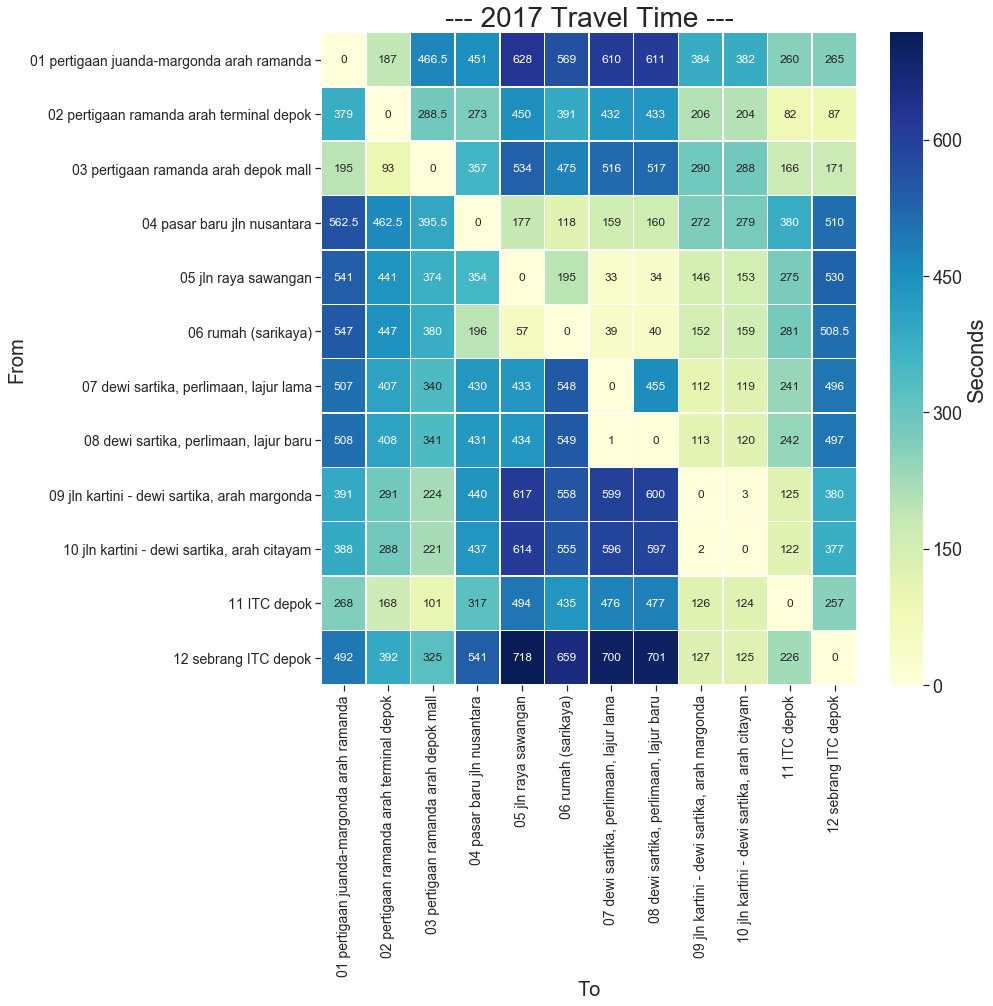

In [9]:
plot_heatmap(df_2017_raw, '--- 2017 Travel Time ---')

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c538dde48>)

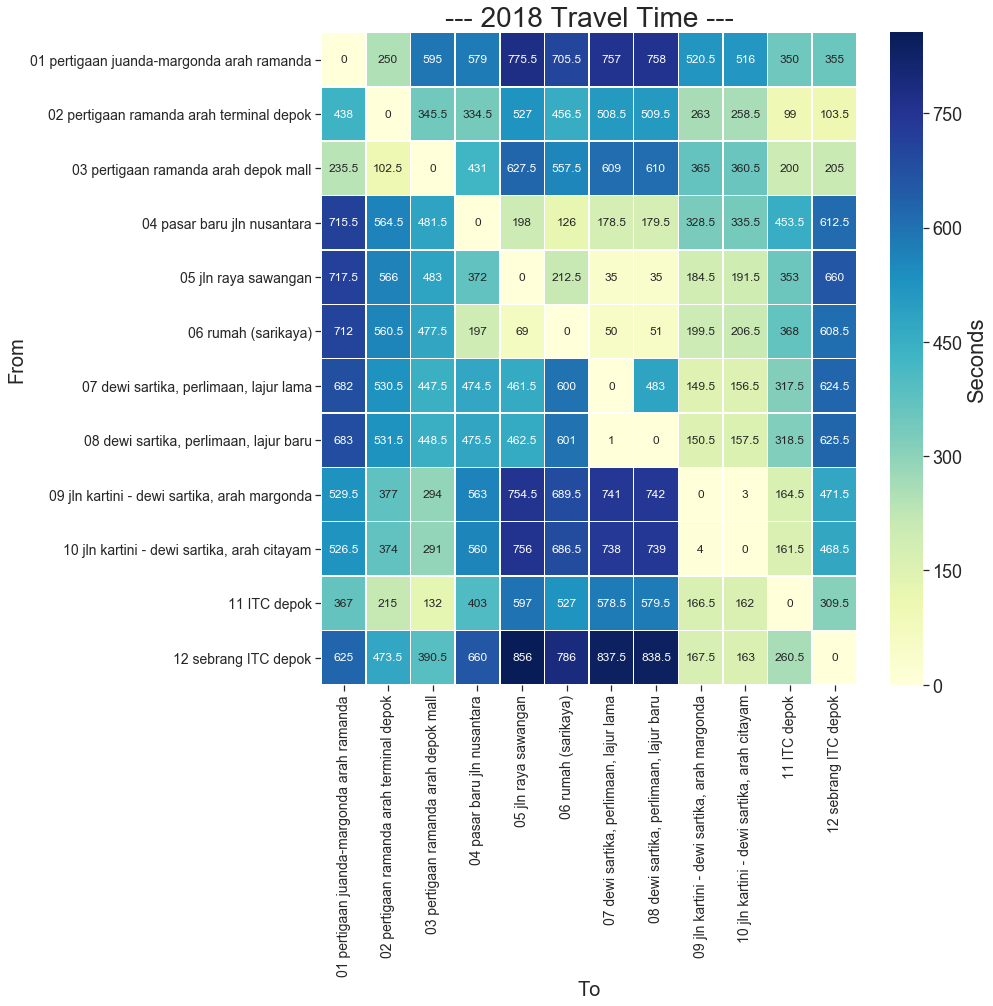

In [10]:
plot_heatmap(df_2018_raw, '--- 2018 Travel Time ---')

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c53c4d9b0>)

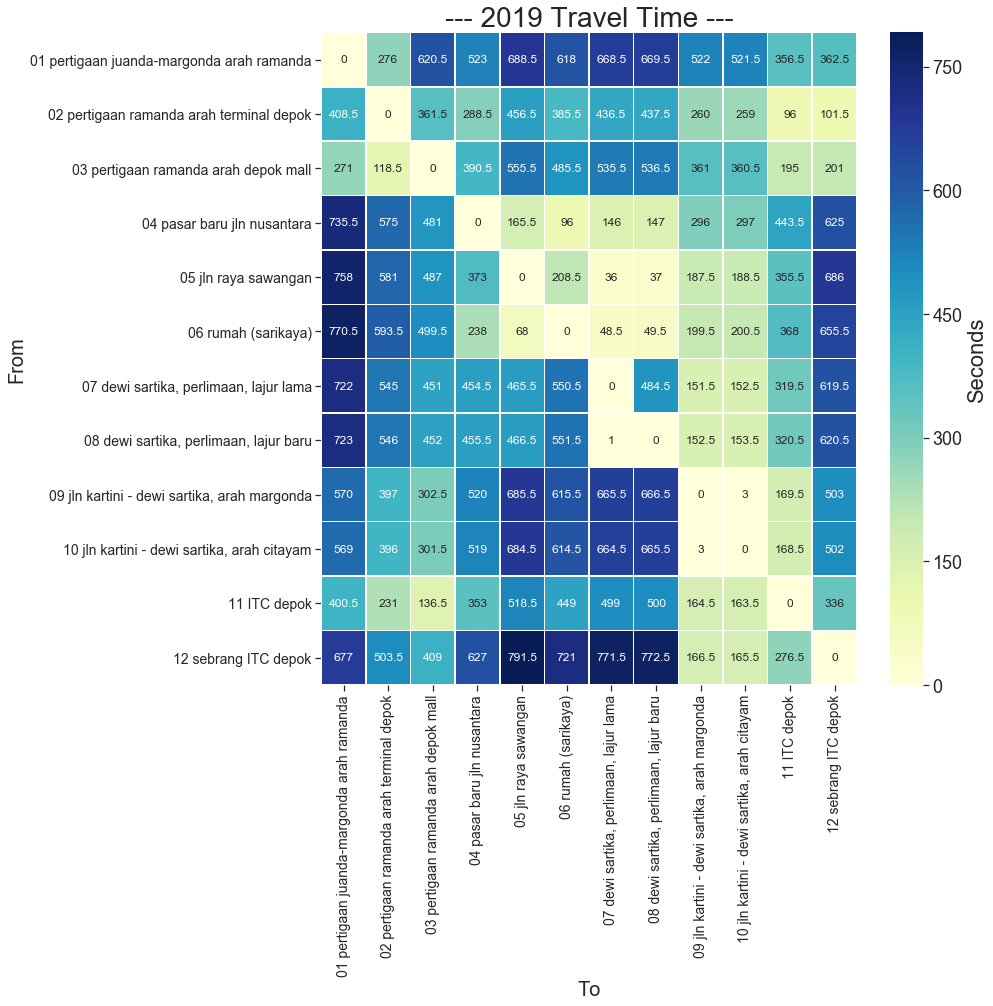

In [11]:
plot_heatmap(df_2019_raw, '--- 2019 Travel Time ---')

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c53c5c358>)

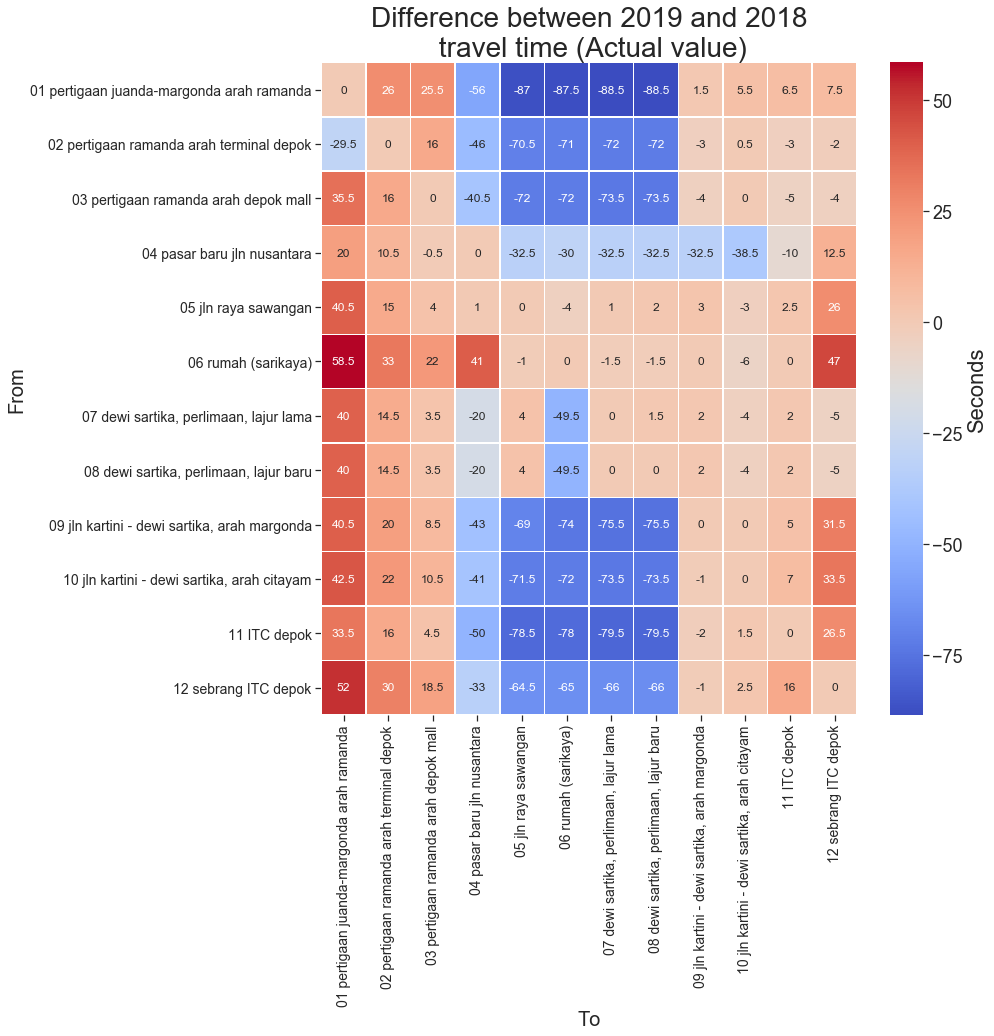

In [12]:
plot_heatmap(difference_raw, 'Difference between 2019 and 2018\n travel time (Actual value)', cmap='coolwarm')

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c55325c88>)

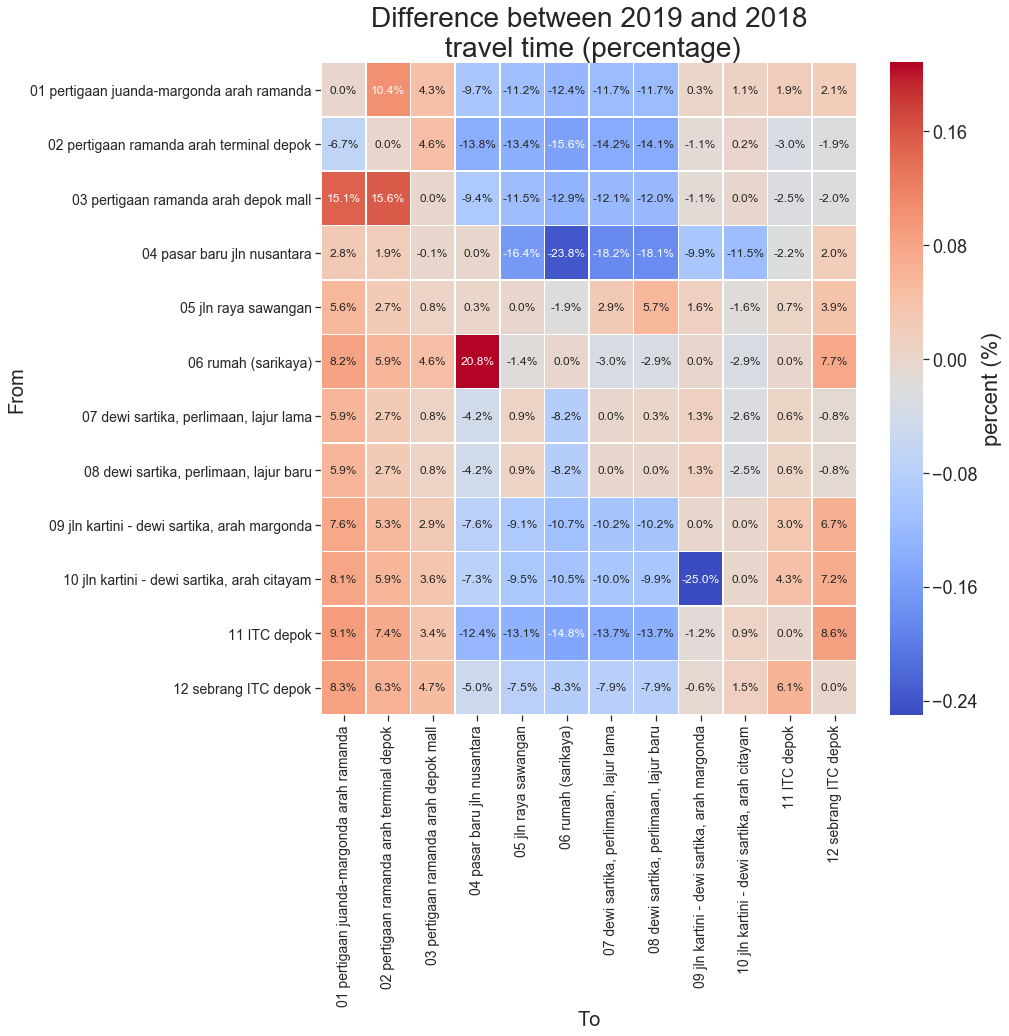

In [13]:
plot_heatmap(difference_perc, 'Difference between 2019 and 2018\n travel time (percentage)',
             cbarlabel='percent (%)', fmt='.1%', cmap='coolwarm')